In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [11]:
chrom = "22"
model = "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True"
min_count_per_consequence = 30

#variants = f"../../results/positions/{chrom}/llr/{model}.subsample_10000000.annot.parquet"
variants = f"../../results/positions/{chrom}/llr/{model}.conserved_pos_full_22.annot.parquet"

V = pl.read_parquet(variants)
V = V.with_columns(
    pl.col("consequence").str.replace("_variant", "")
)
V

chrom,pos,ref,alt,score,consequence
str,i64,str,str,f32,str
"""22""",17145047,"""G""","""A""",-3.816406,"""synonymous"""
"""22""",17145047,"""G""","""C""",-7.462891,"""missense"""
"""22""",17145047,"""G""","""T""",-6.922852,"""missense"""
"""22""",17145049,"""T""","""A""",-10.332031,"""missense"""
"""22""",17145049,"""T""","""C""",-9.749023,"""missense"""
"""22""",17145049,"""T""","""G""",-10.654297,"""missense"""
"""22""",17145050,"""C""","""A""",-11.292969,"""missense"""
"""22""",17145050,"""C""","""G""",-10.032227,"""missense"""
"""22""",17145050,"""C""","""T""",-9.432617,"""missense"""


In [12]:
c_counts = V["consequence"].value_counts().sort("count", descending=True)
c_counts

consequence,count
str,u32
"""missense""",26300
"""stop_gained""",1348
"""splice_accepto…",585
"""splice_donor""",492
"""splice_donor_5…",54
"""stop_lost""",41
"""synonymous""",31
"""splice_donor_r…",30
"""start_lost""",24


In [13]:
c_quantile = V.filter(
    pl.col("consequence").is_in(c_counts.filter(pl.col("count") >= min_count_per_consequence)["consequence"])
).group_by("consequence").agg(pl.quantile("score", 0.01)).sort("score")
c_quantile

consequence,score
str,f32
"""stop_gained""",-13.515625
"""splice_donor_r…",-13.5
"""splice_donor""",-13.484375
"""splice_donor_5…",-13.453125
"""splice_accepto…",-13.4375
"""stop_lost""",-13.296875
"""missense""",-13.195312
"""synonymous""",-7.564453


In [14]:
c_plot = c_quantile["consequence"]
c_plot

consequence
str
"""stop_gained"""
"""splice_donor_r…"
"""splice_donor"""
"""splice_donor_5…"
"""splice_accepto…"
"""stop_lost"""
"""missense"""
"""synonymous"""


In [15]:
score_col = "GPN-MSA score"
df = V.filter(pl.col("consequence").is_in(c_plot)).to_pandas()
df["g"] = df.consequence
df[score_col] = df.score
df['consequence'] = pd.Categorical(df['consequence'], categories=c_plot, ordered=True)
df = df.sort_values("consequence")
df

,chrom,pos,ref,alt,score,consequence,g,GPN-MSA score
4127,22,20933939,G,T,-12.732422,stop_gained,stop_gained,-12.732422
25454,22,41225858,G,A,-11.556641,stop_gained,stop_gained,-11.556641
3678,22,20125363,G,A,-11.732422,stop_gained,stop_gained,-11.732422
12008,22,36298961,T,A,-12.968750,stop_gained,stop_gained,-12.968750
11999,22,36298955,T,A,-12.585938,stop_gained,stop_gained,-12.585938
...,...,...,...,...,...,...,...,...
14594,22,36348919,G,A,-4.208984,synonymous,synonymous,-4.208984
3650,22,20125348,C,T,-3.384766,synonymous,synonymous,-3.384766
20308,22,39313289,G,T,-4.174805,synonymous,synonymous,-4.174805
17936,22,38225512,G,A,-3.796875,synonymous,synonymous,-3.796875


In [16]:
q = 1 / 10_000 #1/2_000
x_left, x_right = df[score_col].quantile(q), df[score_col].quantile(1-q)
x_left, x_right

(-13.8055625, -3.5217812500004086)

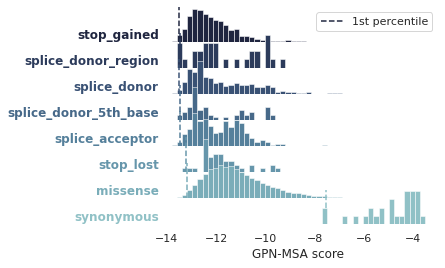

In [17]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

pal = sns.cubehelix_palette(len(c_plot), rot=-.25, light=.7, reverse=True)
g = sns.FacetGrid(
    df, row="g", hue="g",
    aspect=10,#15,
    #height=.5,  # doesn't work
    #height=1, # this works
    height=0.5,
    palette=pal,
    sharey=False,
)

g.map(
    sns.histplot,
    score_col,
    bins=np.linspace(x_left, x_right, 50),
    alpha=1,
    fill=True,
    stat="density",
)

def label(x, color, label):
    ax = plt.gca()
    ax.text(
        0, .2, label, fontweight="bold", color=color,
        ha="right",
        va="center", transform=ax.transAxes
    )
g.map(label, score_col)

def add_quantile(x, color, label):
    ax = plt.gca()
    artist = ax.axvline(x.quantile(0.01), ls='--', color=color)
    
g.map(add_quantile, score_col)

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True);
import matplotlib

artist = [c for c in g.axes[0,0].get_children() if type(c)==matplotlib.lines.Line2D][0]
legend = g.axes[0,0].legend([artist], ["1st percentile"], loc="upper right")
legend.get_frame().set_facecolor('white')
#plt.savefig("../../results/plots/ism.pdf", bbox_inches="tight")
#plt.savefig("../../results/plots/ism_fully_conserved_pos.pdf", bbox_inches="tight")